In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikitavorona","key":"3ab71f514b6616a1a7e396075e5950fe"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!pip install -q kaggle

In [11]:
!kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset

Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset
License(s): CC-BY-SA-4.0
100% 1.47G/1.48G [00:24<00:00, 68.1MB/s]
100% 1.48G/1.48G [00:24<00:00, 65.4MB/s]


In [12]:
!unzip -q the-oxfordiiit-pet-dataset.zip -d ./data

In [13]:
import os

os.listdir('./data')

['images']

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [5]:
random_state = 0xDEAD
np.random.seed(random_state)
torch.random.manual_seed(random_state)
torch.cuda.random.manual_seed_all(random_state);

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [15]:
images = os.listdir('./data/images')

In [16]:
def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]

In [17]:
classes = list(set([get_class(img) for img in images if get_class(img) is not None]))
classes

['saint_bernard',
 'Persian',
 'Siamese',
 'miniature_pinscher',
 'pomeranian',
 'Sphynx',
 'staffordshire_bull_terrier',
 'Birman',
 'beagle',
 'Abyssinian',
 'wheaten_terrier',
 'great_pyrenees',
 'yorkshire_terrier',
 'samoyed',
 'shiba_inu',
 'scottish_terrier',
 'american_pit_bull_terrier',
 'Russian_Blue',
 'Maine_Coon',
 'english_setter',
 'havanese',
 'newfoundland',
 'Bengal',
 'basset_hound',
 'Egyptian_Mau',
 'keeshond',
 'japanese_chin',
 'american_bulldog',
 'Ragdoll',
 'pug',
 'boxer',
 'British_Shorthair',
 'german_shorthaired',
 'english_cocker_spaniel',
 'leonberger',
 'chihuahua',
 'Bombay']

In [18]:
os.makedirs('./dataset')
os.makedirs('./dataset/train')
os.makedirs('./dataset/val')
val_size = 0.2

for cl in classes:
    os.makedirs(os.path.join('dataset/train', cl))
    os.makedirs(os.path.join('dataset/val', cl))

In [19]:
for i, image in enumerate(images):
    cur_class = get_class(image)
    if cur_class is None:
        continue
    if np.random.random(1) < 1 - val_size:
        shutil.copy(os.path.join('./data/images', image), os.path.join('dataset/train', cur_class))
    else:
        shutil.copy(os.path.join('./data/images', image), os.path.join('dataset/val', cur_class))

In [20]:
transform = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_dataset = datasets.ImageFolder('/content/dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/dataset/val', transform=transform)

In [ ]:
len(train_dataset), len(val_dataset)

(5882, 1508)

In [21]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [22]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0

        cur_train_loss = 0
        cur_test_loss = 0

        # training
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # count metrics
            cur_train_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

        # testing
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                cur_test_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.cpu().item()


        train_acc_history.append(cur_train_acc / (len(train_loader) * batch_size))
        test_acc_history.append(cur_test_acc / (len(test_loader) * batch_size))
        train_loss_history.append(cur_train_loss / (len(train_loader) * batch_size))
        test_loss_history.append(cur_test_loss / (len(test_loader) * batch_size))

    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

In [23]:
def plot_loss_history(train_loss_history, test_loss_history):
    plt.figure(figsize=(10, 8))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [24]:
def plot_acc_history(train_acc_history, test_acc_history):
    plt.figure(figsize=(10, 8))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [25]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])

    confustion_matrix = confusion_matrix(reals, preds)
    df_cm = pd.DataFrame(confustion_matrix, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (15, 15))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

In [ ]:
vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.6MB/s]


In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg.classifier[6] = nn.Linear(4096, len(classes))

In [ ]:
vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

epochs = 2

In [ ]:
vgg_stats = train_model(vgg, train_loader, val_loader, epochs, optimizer, criterion, device)

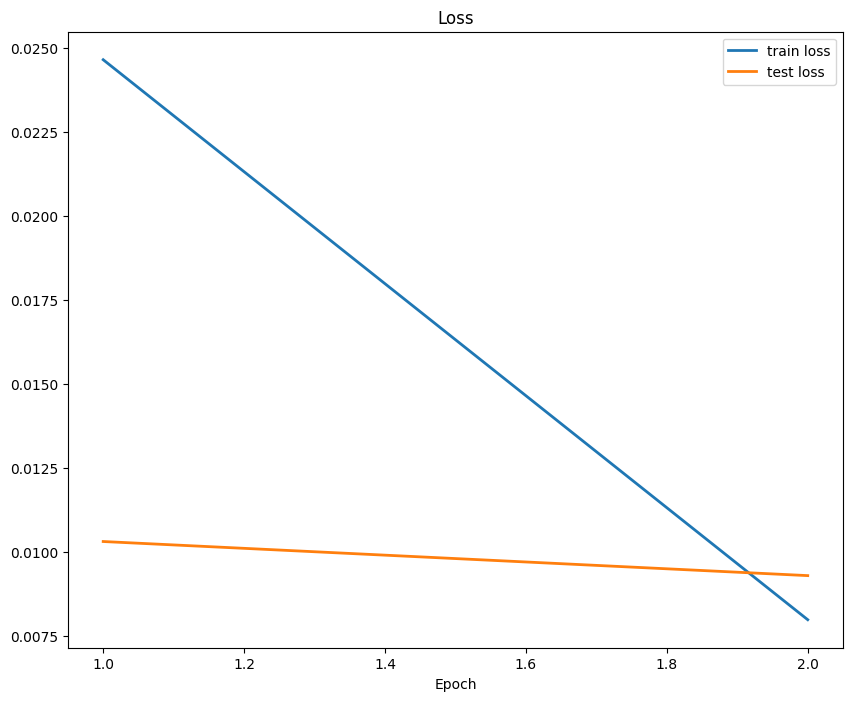

In [ ]:
plot_loss_history(vgg_stats[0], vgg_stats[1])

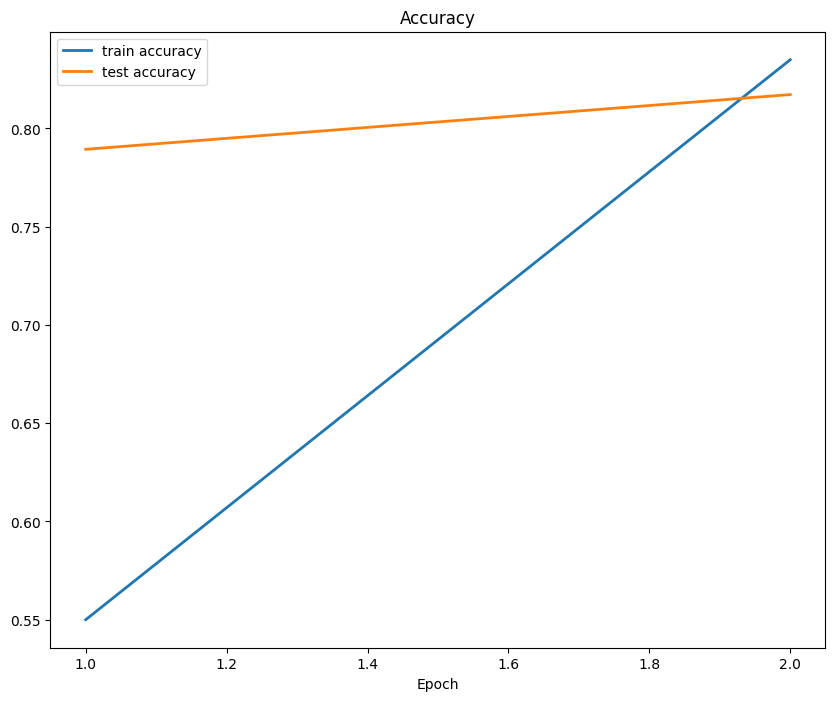

In [ ]:
plot_acc_history(vgg_stats[2], vgg_stats[3])

In [ ]:
print('Final accuracy =', vgg_stats[3][-1])

Final accuracy = 0.8172554347826086


In [27]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


In [28]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
resnet.fc = nn.Linear(512, len(classes))

In [30]:
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

epochs = 2

In [31]:
resnet_stats = train_model(resnet, train_loader, val_loader, epochs, optimizer, criterion, device)

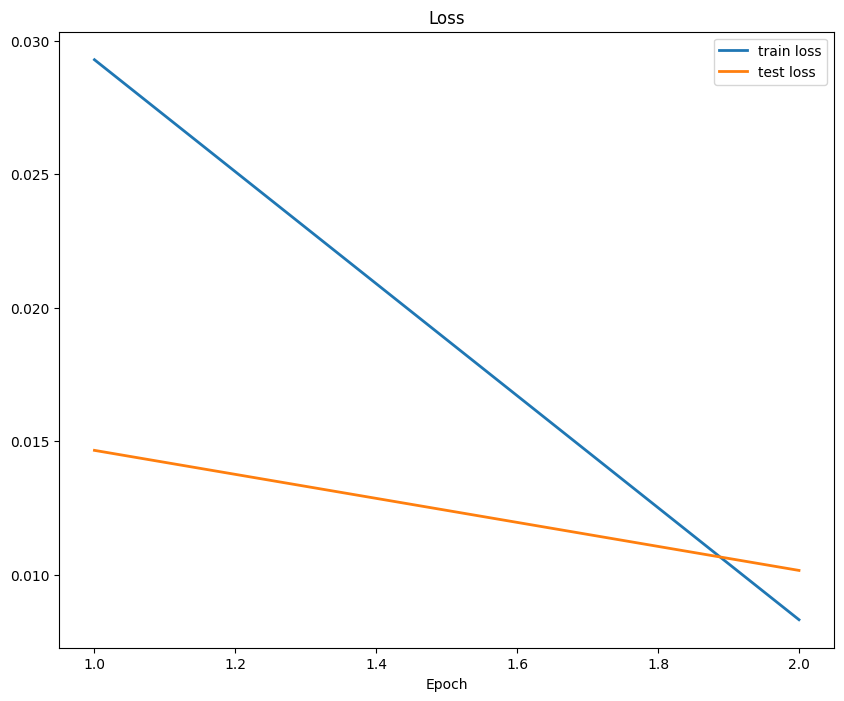

In [32]:
plot_loss_history(resnet_stats[0], resnet_stats[1])

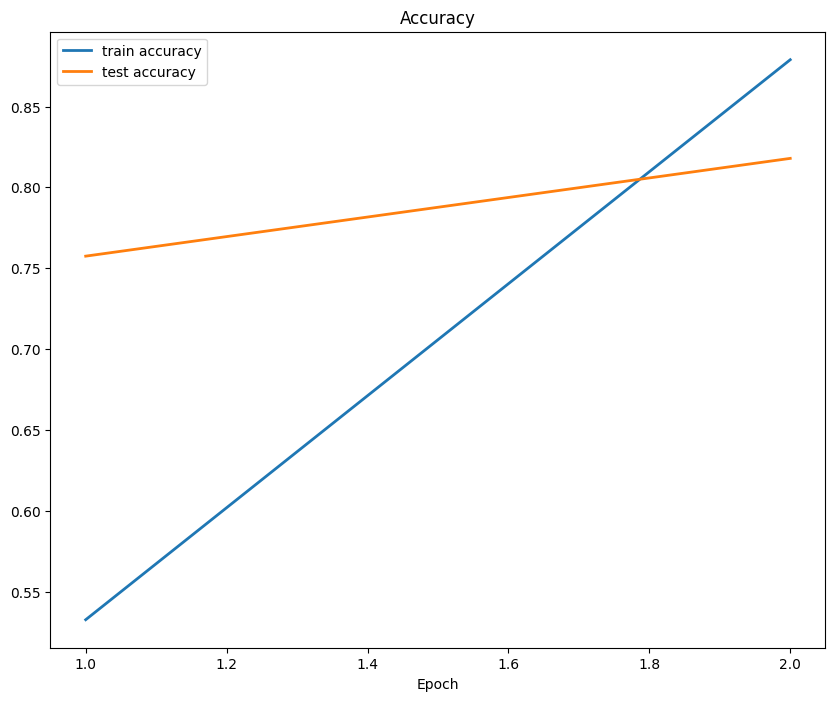

In [33]:
plot_acc_history(resnet_stats[2], resnet_stats[3])

In [34]:
print('Final accuracy =', resnet_stats[3][-1])

Final accuracy = 0.8179347826086957


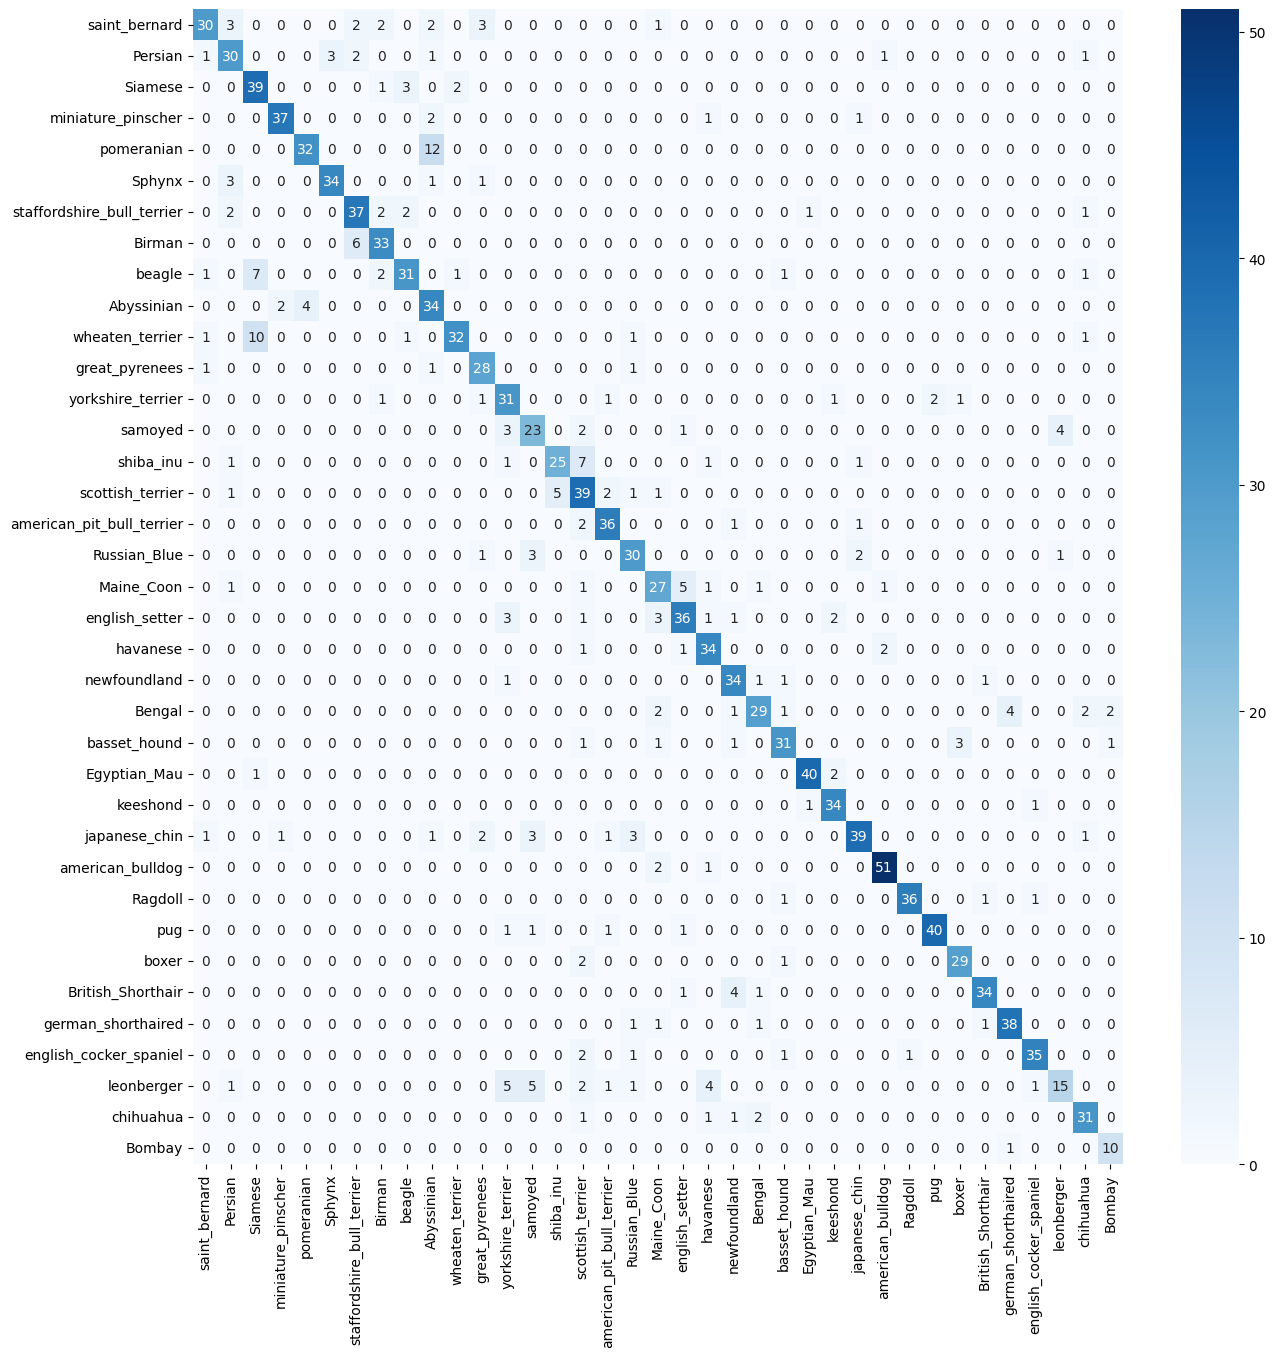

In [35]:
plot_confusion_matrix(resnet, val_loader)

In [40]:
cat_labels = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]

In [41]:
batch_accuracy = []

for (x, y) in val_loader:
  x = x.to(device)
  predictions = torch.argmax(resnet(x), axis = 1)
  binary_labels = [1 if i in cat_labels else 0 for i in predictions]
  binary_y = [1 if i in cat_labels else 0 for i in y]

  faults = 0
  for i in range(len(binary_labels)):
    if binary_labels[i] != binary_y[i]:
      faults += 1
  batch_accuracy.append((len(y)-faults)/len(y))

accuracy = sum(batch_accuracy)/len(batch_accuracy)
accuracy

0.9279891304347826

In [36]:
from sklearn.metrics import top_k_accuracy_score

def get_top_k_accuracy(model, val, k):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = y_pred.cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.vstack([preds, y_pred.cpu().numpy()])
                reals = np.concatenate([reals, y_batch.cpu().numpy()])
    return top_k_accuracy_score(reals, preds, k=k)

In [37]:
get_top_k_accuracy(resnet, val_loader, 3)

0.9565217391304348

In [38]:
get_top_k_accuracy(resnet, val_loader, 5)

0.9755434782608695

In [42]:
1 - (50 / len(val_dataset))

0.9668654738237243